# INFO2950 Final Project Phase 2


## Research Question

Question: Can we reliably predict a New York county's wealth based on their percentage of postgraduates of a certain age and major?

At the conclusion of this project, we seek to determine if there is a correlation between college major and the per capita income of the postgraduate county of residence in New York, and age and the per capita income of the postgraduate county of residence in New York. We will train a multivariable regression on data tables from both Wikepedia and the U.S. Census Bureau to see if we can reliably predict a county's per capita income given the population percentages of Science and Engineering, Business, Education, and Arts, Humanities, and Others for each of these age groups: 25-39 years, 40-64 years, and 65 years and over. Essentially, we aim to determine if college major and age affects the average wealth of where people live.

We defined county wealth using per capita income of the county and we solely considered New York counties for our regression. We defined postgraduates as people holding a Bachelor's degree older than 25 years old. 

## Data Description

We have two data tables from the U.S. Census Bureau and Wikepedia. 

Our data from Wikepedia has one row for each New York State county and there are two columns, one for county name and the other for the county's per capita income. Before we copy-pasted it, on the website, there were additional columns for Median household income, Median family income, Population, and Number of households. We omitted these columns because they did not serve a purpose in our regression. This dataset was created by Wikepedia to inform the public of the income per capita of each county in New York State. The data is originally from the 2010 United States Census Data and the 2006-2010 American Community Survey 5-Year Estimates. The data from the Census is created and collected by the United States government for the purposes of better understanding the demographics of the country and informing policy. Those who participated were aware their data was going to be used for analyzing demographics. We collected this data through copying and pasting the data into an Excel sheet and downloading it as a .csv file. The page is located at the link https://en.wikipedia.org/wiki/List_of_New_York_locations_by_per_capita_income.

We downloaded data from the U.S. Census Bureau's page: https://data.census.gov/table/ACSST1Y2022.S1502?g=040XX00US36,36 using New York State (as a whole) and all New York Counties as filters for their data set, created in 2022. The first column houses the labels of groups of people by age and college major; the following columns pre- data cleaning have each county and the general state's estimate of people falling into each category, the margin of error, percent estimate, percent error, male estimate, male margin of error, male percent estimate, male percent margin of error, female estimate, female margin of error, female percent estimate, and female percent margin of error. Each row is a classification of person, through age range and college major. This dataset was created to gather information about the residents of the United States to better understand the demographics of the country and created more informed policy. This data was created and collected by the government of the United States as a part of the Census, a large survey taken every 10 years. Those who participated in the Census were aware that their data was being used to better understand demographics. There are 5 rows and 469 columns, full of numerical data. No information is missing and the data is self-contained. The data identifies subpopulations by age and gender. Age is used to further divide the groups of majors and gender is used to divide each county's data. This data was accessed using filters to narrow down the dataset to the variables: age, college major, and county.

## Data Cleaning and Collection

### Importing packages

In [1663]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb

### Data cleaning: selecting and extracting the relevant columns of U.S. Census Bureau data table and renaming columns

Read the .csv file:

In [1664]:
census_majors = pd.read_csv("nys_counties_college.csv")
census_majors.columns = census_majors.columns.str.replace("    ", "")

Below, we see that there are many columns that are not relevant to our research question. We are only interested in each county's percent estimate column.

In [1665]:
print(census_majors.head())

                                    Label (Grouping)  \
0  Total population 25 years and over with a Bach...   
1                            Science and Engineering   
2             Science and Engineering Related Fields   
3                                           Business   
4                                          Education   

  New York!!Total!!Estimate New York!!Total!!Margin of Error  \
0                 5,556,561                          ±33,405   
1                 1,951,557                          ±21,418   
2                   513,403                          ±13,232   
3                 1,036,287                          ±19,358   
4                   560,313                          ±13,635   

  New York!!Percent!!Estimate New York!!Percent!!Margin of Error  \
0                         (X)                                (X)   
1                      35.10%                               ±0.4   
2                       9.20%                               ±0.2   
3     

Below, we are replacing the !!s and the spaces with an underscore, then selecting the relevant columns which have each county's total percentage (not including the columns regarding margin or error, total estimate, NYS as a whole, or Male/Female specific columns). There were a lot of columns to be dropped (more than half), so after trying to use .drop(), a TA helped us realize we should just extract the columns of interest and put it into a new dataframe, which we called census_majors_cleaned. We then rename the suffix of each column, _New_York_Percent_Estimate, to County so that we have ___ County as each column's name, so the column names are consistent with the County column of the Wikepedia dataframe.

In [1666]:
census_majors.columns = census_majors.columns.str.replace("!!", "_")
census_majors.columns = census_majors.columns.str.replace(" ", "_")
#Checking that the column names are correct
print(census_majors)

                                     Label_(Grouping) New_York_Total_Estimate  \
0   Total population 25 years and over with a Bach...               5,556,561   
1                             Science and Engineering               1,951,557   
2              Science and Engineering Related Fields                 513,403   
3                                            Business               1,036,287   
4                                           Education                 560,313   
5                         Arts, Humanities and Others               1,495,001   
6                                        DETAILED AGE                     NaN   
7                                      25 to 39 years               2,014,094   
8                             Science and Engineering                 768,173   
9              Science and Engineering Related Fields                 187,112   
10                                           Business                 377,748   
11                          

In [1667]:
census_majors_cleaned = census_majors[['Label_(Grouping)', 'Albany_County,_New_York_Percent_Estimate',
                                       'Bronx_County,_New_York_Percent_Estimate',
                                       'Broome_County,_New_York_Percent_Estimate',
                                       'Cattaraugus_County,_New_York_Percent_Estimate',
                                       'Cayuga_County,_New_York_Percent_Estimate',
                                       'Chautauqua_County,_New_York_Percent_Estimate',
                                       'Chemung_County,_New_York_Percent_Estimate',
                                       'Clinton_County,_New_York_Percent_Estimate',
                                       'Dutchess_County,_New_York_Percent_Estimate',
                                       'Erie_County,_New_York_Percent_Estimate',
                                       'Jefferson_County,_New_York_Percent_Estimate',
                                       'Kings_County,_New_York_Percent_Estimate',
                                       'Madison_County,_New_York_Percent_Estimate',
                                       'Monroe_County,_New_York_Percent_Estimate',
                                       'Nassau_County,_New_York_Percent_Estimate',
                                       'New_York_County,_New_York_Percent_Estimate',
                                       'Niagara_County,_New_York_Percent_Estimate',
                                       'Oneida_County,_New_York_Percent_Estimate',
                                       'Onondaga_County,_New_York_Percent_Estimate',
                                       'Ontario_County,_New_York_Percent_Estimate',
                                       'Orange_County,_New_York_Percent_Estimate',
                                       'Oswego_County,_New_York_Percent_Estimate',
                                       'Putnam_County,_New_York_Percent_Estimate',
                                       'Queens_County,_New_York_Percent_Estimate',
                                       'Rensselaer_County,_New_York_Percent_Estimate',
                                       'Richmond_County,_New_York_Percent_Estimate',
                                       'Rockland_County,_New_York_Percent_Estimate',
                                       'St._Lawrence_County,_New_York_Percent_Estimate',
                                       'Saratoga_County,_New_York_Percent_Estimate',
                                       'Schenectady_County,_New_York_Percent_Estimate',
                                       'Steuben_County,_New_York_Percent_Estimate',
                                       'Suffolk_County,_New_York_Percent_Estimate',
                                       'Sullivan_County,_New_York_Percent_Estimate',
                                       'Tompkins_County,_New_York_Percent_Estimate',
                                       'Ulster_County,_New_York_Percent_Estimate',
                                       'Warren_County,_New_York_Percent_Estimate',
                                       'Wayne_County,_New_York_Percent_Estimate',
                                       'Westchester_County,_New_York_Percent_Estimate',
                                      ]]
#Getting rid of added title (we just want the county name + "County")
census_majors_cleaned.columns = census_majors_cleaned.columns.str.replace(",_New_York_Percent_Estimate", "")
census_majors_cleaned.columns = census_majors_cleaned.columns.str.replace("_", " ")
#Checking to make sure the dataframe has the columns we want
census_majors_cleaned.set_index('Label (Grouping)', inplace=True)
census_majors_cleaned.index.str.strip()
display(census_majors_cleaned)

,Albany County,Bronx County,Broome County,Cattaraugus County,Cayuga County,Chautauqua County,Chemung County,Clinton County,Dutchess County,Erie County,...,Saratoga County,Schenectady County,Steuben County,Suffolk County,Sullivan County,Tompkins County,Ulster County,Warren County,Wayne County,Westchester County
Label (Grouping),,,,,,,,,,,,,,,,,,,,,
Total population 25 years and over with a Bachelor's degree or higher,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
Science and Engineering,42.80%,32.90%,39.50%,34.50%,33.60%,30.70%,32.00%,26.30%,34.50%,32.20%,...,43.00%,39.40%,36.20%,31.50%,31.70%,51.10%,29.50%,32.60%,39.20%,36.60%
Science and Engineering Related Fields,8.40%,11.70%,8.80%,8.30%,7.30%,14.00%,10.40%,12.10%,7.80%,11.40%,...,7.60%,8.00%,11.40%,11.10%,7.70%,4.40%,5.50%,10.10%,11.00%,8.20%
Business,14.30%,19.70%,16.20%,16.60%,17.50%,11.80%,14.30%,14.30%,15.70%,19.90%,...,17.20%,18.10%,14.90%,21.70%,11.20%,8.30%,16.10%,14.10%,17.80%,19.10%
Education,11.30%,10.50%,13.50%,20.40%,19.10%,19.50%,17.80%,22.50%,11.90%,12.70%,...,11.00%,11.40%,15.40%,13.80%,15.30%,5.80%,12.10%,22.20%,15.10%,8.10%
"Arts, Humanities and Others",23.20%,25.20%,22.00%,20.20%,22.40%,24.00%,25.50%,24.80%,30.10%,23.70%,...,21.30%,23.10%,22.10%,21.90%,34.10%,30.40%,36.90%,21.00%,17.00%,28.00%
DETAILED AGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25 to 39 years,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
Science and Engineering,47.00%,37.10%,43.00%,36.10%,34.60%,22.90%,45.00%,23.30%,38.70%,36.40%,...,43.40%,48.80%,37.30%,34.90%,39.80%,55.50%,35.40%,36.30%,45.20%,39.60%


We want to merge this data with the wikepedia data, so we will align the county names as rows because a taller dataframe is better for regressions. We will use .transpose() to switch the columns and the rows of the cleaned census data. After performing the above, we realized we have to set the index to our "Label (Grouping)" column, so we used set_index() above the transpose() command so we could access the right index with the set_index()

In [1668]:
census_majors_cleaned = census_majors_cleaned.transpose()
census_majors_cleaned.rename(columns = {'Label (Grouping)':'County'}, inplace = True)
display(census_majors_cleaned)

Label (Grouping),Total population 25 years and over with a Bachelor's degree or higher,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",DETAILED AGE,25 to 39 years,Science and Engineering,Science and Engineering Related Fields,...,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",65 years and over,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
Albany County,(X),42.80%,8.40%,14.30%,11.30%,23.20%,NaN,(X),47.00%,9.90%,...,7.70%,15.00%,11.00%,23.70%,(X),36.50%,7.30%,16.80%,21.60%,17.80%
Bronx County,(X),32.90%,11.70%,19.70%,10.50%,25.20%,NaN,(X),37.10%,11.70%,...,11.50%,21.20%,11.80%,25.00%,(X),29.10%,12.00%,13.10%,21.40%,24.40%
Broome County,(X),39.50%,8.80%,16.20%,13.50%,22.00%,NaN,(X),43.00%,9.20%,...,6.60%,22.00%,13.40%,20.70%,(X),38.70%,11.90%,11.90%,21.70%,15.70%
Cattaraugus County,(X),34.50%,8.30%,16.60%,20.40%,20.20%,NaN,(X),36.10%,7.10%,...,9.60%,18.50%,20.90%,19.00%,(X),36.80%,7.50%,17.20%,21.80%,16.70%
Cayuga County,(X),33.60%,7.30%,17.50%,19.10%,22.40%,NaN,(X),34.60%,5.80%,...,7.90%,22.80%,15.60%,16.10%,(X),26.20%,8.20%,13.00%,33.10%,19.50%
Chautauqua County,(X),30.70%,14.00%,11.80%,19.50%,24.00%,NaN,(X),22.90%,12.10%,...,13.00%,15.90%,17.20%,17.80%,(X),26.60%,17.50%,4.40%,26.20%,25.30%
Chemung County,(X),32.00%,10.40%,14.30%,17.80%,25.50%,NaN,(X),45.00%,14.00%,...,5.40%,22.20%,19.30%,27.10%,(X),27.40%,14.60%,14.60%,29.90%,13.50%
Clinton County,(X),26.30%,12.10%,14.30%,22.50%,24.80%,NaN,(X),23.30%,18.20%,...,9.20%,16.90%,18.10%,27.70%,(X),26.30%,10.60%,8.70%,33.60%,20.90%
Dutchess County,(X),34.50%,7.80%,15.70%,11.90%,30.10%,NaN,(X),38.70%,8.90%,...,6.20%,20.40%,11.20%,29.30%,(X),32.00%,9.30%,9.50%,21.70%,27.50%
Erie County,(X),32.20%,11.40%,19.90%,12.70%,23.70%,NaN,(X),36.40%,11.10%,...,11.50%,22.40%,12.20%,23.70%,(X),29.10%,12.00%,13.60%,22.70%,22.60%


Now we have to create an index for each row, because we want the county to be a column rather than an index, since we cannot use a County index like we would with a column as a key when merging dataframes.

In [1669]:
census_majors_cleaned.reset_index(inplace=True)
census_majors_cleaned.rename(columns = {'index':'County'}, inplace = True)
census_majors_cleaned.columns = census_majors_cleaned.columns.str.replace("    ", "")

display(census_majors_cleaned)

Label (Grouping),County,Total population 25 years and over with a Bachelor's degree or higher,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",DETAILED AGE,25 to 39 years,Science and Engineering,...,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",65 years and over,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,Albany County,(X),42.80%,8.40%,14.30%,11.30%,23.20%,NaN,(X),47.00%,...,7.70%,15.00%,11.00%,23.70%,(X),36.50%,7.30%,16.80%,21.60%,17.80%
1,Bronx County,(X),32.90%,11.70%,19.70%,10.50%,25.20%,NaN,(X),37.10%,...,11.50%,21.20%,11.80%,25.00%,(X),29.10%,12.00%,13.10%,21.40%,24.40%
2,Broome County,(X),39.50%,8.80%,16.20%,13.50%,22.00%,NaN,(X),43.00%,...,6.60%,22.00%,13.40%,20.70%,(X),38.70%,11.90%,11.90%,21.70%,15.70%
3,Cattaraugus County,(X),34.50%,8.30%,16.60%,20.40%,20.20%,NaN,(X),36.10%,...,9.60%,18.50%,20.90%,19.00%,(X),36.80%,7.50%,17.20%,21.80%,16.70%
4,Cayuga County,(X),33.60%,7.30%,17.50%,19.10%,22.40%,NaN,(X),34.60%,...,7.90%,22.80%,15.60%,16.10%,(X),26.20%,8.20%,13.00%,33.10%,19.50%
5,Chautauqua County,(X),30.70%,14.00%,11.80%,19.50%,24.00%,NaN,(X),22.90%,...,13.00%,15.90%,17.20%,17.80%,(X),26.60%,17.50%,4.40%,26.20%,25.30%
6,Chemung County,(X),32.00%,10.40%,14.30%,17.80%,25.50%,NaN,(X),45.00%,...,5.40%,22.20%,19.30%,27.10%,(X),27.40%,14.60%,14.60%,29.90%,13.50%
7,Clinton County,(X),26.30%,12.10%,14.30%,22.50%,24.80%,NaN,(X),23.30%,...,9.20%,16.90%,18.10%,27.70%,(X),26.30%,10.60%,8.70%,33.60%,20.90%
8,Dutchess County,(X),34.50%,7.80%,15.70%,11.90%,30.10%,NaN,(X),38.70%,...,6.20%,20.40%,11.20%,29.30%,(X),32.00%,9.30%,9.50%,21.70%,27.50%
9,Erie County,(X),32.20%,11.40%,19.90%,12.70%,23.70%,NaN,(X),36.40%,...,11.50%,22.40%,12.20%,23.70%,(X),29.10%,12.00%,13.60%,22.70%,22.60%


Now we are ready to split this data into other subgroups and merge this data with the Wikepedia data!

### Data collection: web scraping from Wikepedia's "List of New York locations by per capita":

We attempted to data scrape the Wikepedia website, but we were unsuccessful because the < tr > tags that contained the data we were trying to scrape did not have a class associated with them, and TAs we consulted recommended manually pasting the data into an Excel spreadsheet and downloading it as a .csv file instead. Below, you will find our initial web scraping process, from saving the url to opening the html file up to where we realized there was no clear way to scrape without a class in the < tr > tag. 

In [1670]:
wikepedia_url = "https://en.wikipedia.org/wiki/List_of_New_York_locations_by_per_capita_income"

In [1671]:
wikepedia_result = requests.get(wikepedia_url)

In [1672]:
with open("county_wealth.html", "w") as writer:
    writer.write(wikepedia_result.text)

In [1673]:
with open("county_wealth.html", "r") as reader:
    html_source = reader.read()

In [1674]:
# Confidence check
html_source[:20]

'<!DOCTYPE html>\n<htm'

In [1675]:
page = BeautifulSoup(html_source, "html.parser")

Below, you will find that there are no classes in the < tr > tags that we scraped.

In [1676]:
wikepedia_county_income = page.find("table", {"class": "wikitable"})
wikepedia_county_income = wikepedia_county_income.find_next('tbody').find_all('tr')
print(wikepedia_county_income)

[<tr valign="bottom">
<th>Rank
</th>
<th>County
</th>
<th>Per capita<br/>income
</th>
<th>Median<br/>household<br/>income
</th>
<th>Median<br/>family<br/>income
</th>
<th>Population
</th>
<th>Number of<br/>households
</th></tr>, <tr>
<td>1
</td>
<td><a href="/wiki/Manhattan" title="Manhattan">New York County</a>
</td>
<td>$111,386
</td>
<td>$64,971
</td>
<td>$75,629
</td>
<td>1,585,873
</td>
<td>763,846
</td></tr>, <tr>
<td>2
</td>
<td><a href="/wiki/Westchester_County,_New_York" title="Westchester County, New York">Westchester</a>
</td>
<td>$73,159
</td>
<td>$79,619
</td>
<td>$100,863
</td>
<td>949,113
</td>
<td>347,232
</td></tr>, <tr>
<td>3
</td>
<td><a href="/wiki/Nassau_County,_New_York" title="Nassau County, New York">Nassau</a>
</td>
<td>$41,387
</td>
<td>$93,613
</td>
<td>$107,934
</td>
<td>1,339,532
</td>
<td>448,528
</td></tr>, <tr>
<td>4
</td>
<td><a href="/wiki/Putnam_County,_New_York" title="Putnam County, New York">Putnam</a>
</td>
<td>$37,915
</td>
<td>$89,218
</td>
<td>

### Data collection: Excel and downloading the Wikepedia table

Thus, we manually copy-pasted the Wikepedia data into Excel and downloaded that file as a .csv

In [1677]:
county_wealth = pd.read_csv("county_wealth.csv")
print(county_wealth)

             County Per capita income
0   New York County          111, 386
1       Westchester           73, 159
2            Nassau           41, 387
3            Putnam           37, 915
4           Suffolk           35, 755
..              ...               ...
57          Wyoming           20, 605
58     St. Lawrence           20, 143
59         Allegany           20, 058
60         Franklin           19, 807
61            Bronx           17, 575

[62 rows x 2 columns]


### Data Cleaning: Adding "County" to the county names in county_wealth

To perform an inner join on the tables, we have to rename each row of the "County" column of county_wealth, since the county name does not have "county" after it, as it does in census_majors' county columns.

In [1678]:
county_wealth['County'] = county_wealth['County'] + ' County'
county_wealth['County'].iloc[[0]] = 'New York County'
display(county_wealth)

,County,Per capita income
0,New York County,"111, 386"
1,Westchester County,"73, 159"
2,Nassau County,"41, 387"
3,Putnam County,"37, 915"
4,Suffolk County,"35, 755"
...,...,...
57,Wyoming County,"20, 605"
58,St. Lawrence County,"20, 143"
59,Allegany County,"20, 058"
60,Franklin County,"19, 807"


We also have to change the Per capita income from a string to an integer.

In [1679]:
county_wealth['Per capita income'] = county_wealth['Per capita income'].str.replace('  ,', '')
county_wealth['Per capita income'] = county_wealth['Per capita income'].str.replace(', ', '')
county_wealth['Per capita income'] = county_wealth['Per capita income'].astype(int)
print(county_wealth['Per capita income'].dtypes)
display(county_wealth)

int64


,County,Per capita income
0,New York County,111386
1,Westchester County,73159
2,Nassau County,41387
3,Putnam County,37915
4,Suffolk County,35755
...,...,...
57,Wyoming County,20605
58,St. Lawrence County,20143
59,Allegany County,20058
60,Franklin County,19807


### Data cleaning: splitting census data

Here we are splitting the data into two subsets:
- One dataframe where the age is disregarded and all of the ages are compiled into one major, so that there is one value for each major (ageless_majors)
- Three dataframes where each age is displayed in full on its own (young_majors, middle_majors, old_majors)

After we create these, we display each dataframe and then merge it with the wikepedia dataframe. We want to merge this via a left join to combine the data unique to each individual dataframe being joined so we can look at specific age's majors' impact on county income per capita. 

In [1680]:
only_census_total = census_majors_cleaned.iloc[:, 1: 7]
ageless_majors = only_census_total.drop(columns=["Total population 25 years and over with a Bachelor's degree or higher"])
ageless_majors['County'] = census_majors_cleaned['County']
display(ageless_majors)

Label (Grouping),Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",County
0,42.80%,8.40%,14.30%,11.30%,23.20%,Albany County
1,32.90%,11.70%,19.70%,10.50%,25.20%,Bronx County
2,39.50%,8.80%,16.20%,13.50%,22.00%,Broome County
3,34.50%,8.30%,16.60%,20.40%,20.20%,Cattaraugus County
4,33.60%,7.30%,17.50%,19.10%,22.40%,Cayuga County
5,30.70%,14.00%,11.80%,19.50%,24.00%,Chautauqua County
6,32.00%,10.40%,14.30%,17.80%,25.50%,Chemung County
7,26.30%,12.10%,14.30%,22.50%,24.80%,Clinton County
8,34.50%,7.80%,15.70%,11.90%,30.10%,Dutchess County
9,32.20%,11.40%,19.90%,12.70%,23.70%,Erie County


In [1681]:
young_majors = census_majors_cleaned.iloc[:, 9:14]
young_majors['County'] = census_majors_cleaned['County']
display(young_majors)

/var/folders/nr/9hclh7mn701cybd7y57ldjs40000gn/T/ipykernel_82694/1488484073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  young_majors['County'] = census_majors_cleaned['County']


Label (Grouping),Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",County
0,47.00%,9.90%,12.00%,5.30%,25.80%,Albany County
1,37.10%,11.70%,21.20%,4.20%,25.70%,Bronx County
2,43.00%,9.20%,11.90%,7.00%,28.80%,Broome County
3,36.10%,7.10%,13.10%,18.30%,25.40%,Cattaraugus County
4,34.60%,5.80%,14.00%,10.50%,35.10%,Cayuga County
5,22.90%,12.10%,10.90%,17.10%,36.90%,Chautauqua County
6,45.00%,14.00%,2.30%,4.90%,33.80%,Chemung County
7,23.30%,18.20%,14.50%,20.70%,23.30%,Clinton County
8,38.70%,8.90%,14.00%,4.90%,33.40%,Dutchess County
9,36.40%,11.10%,20.50%,7.80%,24.20%,Erie County


In [1682]:
middle_majors = census_majors_cleaned.iloc[:, 15:20]
middle_majors['County'] = census_majors_cleaned['County']
display(middle_majors)

/var/folders/nr/9hclh7mn701cybd7y57ldjs40000gn/T/ipykernel_82694/1151616634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  middle_majors['County'] = census_majors_cleaned['County']


Label (Grouping),Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",County
0,42.60%,7.70%,15.00%,11.00%,23.70%,Albany County
1,30.50%,11.50%,21.20%,11.80%,25.00%,Bronx County
2,37.40%,6.60%,22.00%,13.40%,20.70%,Broome County
3,32.10%,9.60%,18.50%,20.90%,19.00%,Cattaraugus County
4,37.70%,7.90%,22.80%,15.60%,16.10%,Cayuga County
5,36.20%,13.00%,15.90%,17.20%,17.80%,Chautauqua County
6,26.10%,5.40%,22.20%,19.30%,27.10%,Chemung County
7,28.10%,9.20%,16.90%,18.10%,27.70%,Clinton County
8,32.90%,6.20%,20.40%,11.20%,29.30%,Dutchess County
9,30.20%,11.50%,22.40%,12.20%,23.70%,Erie County


In [1683]:
old_majors = census_majors_cleaned.iloc[:, 21:26]
old_majors['County'] = census_majors_cleaned['County']
display(old_majors)

/var/folders/nr/9hclh7mn701cybd7y57ldjs40000gn/T/ipykernel_82694/3080370734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_majors['County'] = census_majors_cleaned['County']


Label (Grouping),Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",County
0,36.50%,7.30%,16.80%,21.60%,17.80%,Albany County
1,29.10%,12.00%,13.10%,21.40%,24.40%,Bronx County
2,38.70%,11.90%,11.90%,21.70%,15.70%,Broome County
3,36.80%,7.50%,17.20%,21.80%,16.70%,Cattaraugus County
4,26.20%,8.20%,13.00%,33.10%,19.50%,Cayuga County
5,26.60%,17.50%,4.40%,26.20%,25.30%,Chautauqua County
6,27.40%,14.60%,14.60%,29.90%,13.50%,Chemung County
7,26.30%,10.60%,8.70%,33.60%,20.90%,Clinton County
8,32.00%,9.30%,9.50%,21.70%,27.50%,Dutchess County
9,29.10%,12.00%,13.60%,22.70%,22.60%,Erie County


### Data cleaning: merging dataframes

We want to merge our cleaned census dataframe with our wikepedia dataframe for comparison purposes. We will use a LEFT JOIN on the county key, because both dataframes have a county column.

In [1684]:
merged_df = county_wealth.merge(census_majors_cleaned, left_on='County', right_on ='County')
display(merged_df)

,County,Per capita income,Total population 25 years and over with a Bachelor's degree or higher,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",DETAILED AGE,25 to 39 years,...,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",65 years and over,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,(X),38.30%,4.40%,18.30%,3.80%,35.30%,NaN,(X),...,4.20%,19.50%,3.70%,38.30%,(X),33.60%,5.10%,8.20%,7.70%,45.40%
1,Westchester County,73159,(X),36.60%,8.20%,19.10%,8.10%,28.00%,NaN,(X),...,7.40%,21.80%,5.60%,28.20%,(X),32.10%,9.30%,13.70%,16.80%,28.20%
2,Nassau County,41387,(X),32.60%,11.30%,23.50%,11.20%,21.40%,NaN,(X),...,10.80%,26.30%,9.60%,20.20%,(X),29.70%,10.20%,18.70%,19.10%,22.30%
3,Putnam County,37915,(X),27.30%,11.20%,17.80%,12.50%,31.20%,NaN,(X),...,11.40%,19.50%,11.50%,29.30%,(X),29.50%,13.30%,10.20%,17.50%,29.50%
4,Suffolk County,35755,(X),31.50%,11.10%,21.70%,13.80%,21.90%,NaN,(X),...,10.60%,25.40%,13.20%,21.50%,(X),32.00%,10.20%,14.30%,18.70%,24.70%
5,Rockland County,34304,(X),31.60%,12.00%,21.70%,13.40%,21.30%,NaN,(X),...,10.70%,26.50%,11.30%,21.40%,(X),36.00%,11.50%,15.90%,19.90%,16.60%
6,Saratoga County,32186,(X),43.00%,7.60%,17.20%,11.00%,21.30%,NaN,(X),...,6.20%,20.90%,9.80%,20.00%,(X),42.30%,6.50%,11.10%,17.90%,22.20%
7,Dutchess County,31642,(X),34.50%,7.80%,15.70%,11.90%,30.10%,NaN,(X),...,6.20%,20.40%,11.20%,29.30%,(X),32.00%,9.30%,9.50%,21.70%,27.50%
8,Albany County,30863,(X),42.80%,8.40%,14.30%,11.30%,23.20%,NaN,(X),...,7.70%,15.00%,11.00%,23.70%,(X),36.50%,7.30%,16.80%,21.60%,17.80%
9,Richmond County,30843,(X),33.30%,12.10%,21.30%,12.90%,20.30%,NaN,(X),...,11.90%,24.80%,13.00%,16.90%,(X),35.90%,9.00%,17.50%,16.30%,21.30%


Here we will merge the non-age-specific dataframe with the county_wealth dataframe.

In [1685]:
ageless_merged_df = county_wealth.merge(ageless_majors, left_on='County', right_on ='County')
display(ageless_merged_df)

,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,38.30%,4.40%,18.30%,3.80%,35.30%
1,Westchester County,73159,36.60%,8.20%,19.10%,8.10%,28.00%
2,Nassau County,41387,32.60%,11.30%,23.50%,11.20%,21.40%
3,Putnam County,37915,27.30%,11.20%,17.80%,12.50%,31.20%
4,Suffolk County,35755,31.50%,11.10%,21.70%,13.80%,21.90%
5,Rockland County,34304,31.60%,12.00%,21.70%,13.40%,21.30%
6,Saratoga County,32186,43.00%,7.60%,17.20%,11.00%,21.30%
7,Dutchess County,31642,34.50%,7.80%,15.70%,11.90%,30.10%
8,Albany County,30863,42.80%,8.40%,14.30%,11.30%,23.20%
9,Richmond County,30843,33.30%,12.10%,21.30%,12.90%,20.30%


We also merged each of the age-specific data frames with the county_wealth dataframe.

In [1686]:
young_merged_df = county_wealth.merge(young_majors, left_on='County', right_on ='County')
display(young_merged_df)

,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,43.50%,4.20%,21.70%,2.10%,28.40%
1,Westchester County,73159,39.60%,8.80%,18.60%,5.50%,27.50%
2,Nassau County,41387,34.00%,12.80%,22.40%,8.10%,22.60%
3,Putnam County,37915,24.30%,9.30%,20.20%,10.70%,35.40%
4,Suffolk County,35755,34.90%,12.60%,21.00%,11.00%,20.50%
5,Rockland County,34304,30.00%,14.50%,19.00%,11.30%,25.30%
6,Saratoga County,32186,43.40%,10.80%,15.50%,7.50%,22.90%
7,Dutchess County,31642,38.70%,8.90%,14.00%,4.90%,33.40%
8,Albany County,30863,47.00%,9.90%,12.00%,5.30%,25.80%
9,Richmond County,30843,31.80%,14.00%,18.90%,11.20%,24.00%


In [1687]:
middle_merged_df = county_wealth.merge(middle_majors, left_on='County', right_on ='County')
display(middle_merged_df)

,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,34.40%,4.20%,19.50%,3.70%,38.30%
1,Westchester County,73159,37.00%,7.40%,21.80%,5.60%,28.20%
2,Nassau County,41387,33.10%,10.80%,26.30%,9.60%,20.20%
3,Putnam County,37915,28.20%,11.40%,19.50%,11.50%,29.30%
4,Suffolk County,35755,29.30%,10.60%,25.40%,13.20%,21.50%
5,Rockland County,34304,30.20%,10.70%,26.50%,11.30%,21.40%
6,Saratoga County,32186,43.10%,6.20%,20.90%,9.80%,20.00%
7,Dutchess County,31642,32.90%,6.20%,20.40%,11.20%,29.30%
8,Albany County,30863,42.60%,7.70%,15.00%,11.00%,23.70%
9,Richmond County,30843,33.40%,11.90%,24.80%,13.00%,16.90%


In [1688]:
old_merged_df = county_wealth.merge(old_majors, left_on='County', right_on ='County')
display(old_merged_df)

,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,33.60%,5.10%,8.20%,7.70%,45.40%
1,Westchester County,73159,32.10%,9.30%,13.70%,16.80%,28.20%
2,Nassau County,41387,29.70%,10.20%,18.70%,19.10%,22.30%
3,Putnam County,37915,29.50%,13.30%,10.20%,17.50%,29.50%
4,Suffolk County,35755,32.00%,10.20%,14.30%,18.70%,24.70%
5,Rockland County,34304,36.00%,11.50%,15.90%,19.90%,16.60%
6,Saratoga County,32186,42.30%,6.50%,11.10%,17.90%,22.20%
7,Dutchess County,31642,32.00%,9.30%,9.50%,21.70%,27.50%
8,Albany County,30863,36.50%,7.30%,16.80%,21.60%,17.80%
9,Richmond County,30843,35.90%,9.00%,17.50%,16.30%,21.30%


Lastly, we will get rid of the percent signs for the county's college major data and convert the strings into floats.

We will start by getting rid of the %s in the ageless_majors dataframe:

In [1689]:
ageless_merged_df['Science and Engineering'] = ageless_merged_df['Science and Engineering'].str.replace('%', '')
ageless_merged_df['Science and Engineering'].astype(float)
ageless_merged_df['Science and Engineering Related Fields'] = ageless_merged_df['Science and Engineering Related Fields'].str.replace('%', '')
ageless_merged_df['Science and Engineering Related Fields'].astype(float)
ageless_merged_df['Business'] = ageless_merged_df['Business'].str.replace('%', '')
ageless_merged_df['Business'].astype(float)
ageless_merged_df['Education'] = ageless_merged_df['Education'].str.replace('%', '')
ageless_merged_df['Education'].astype(float)
ageless_merged_df['Arts, Humanities and Others'] = ageless_merged_df['Arts, Humanities and Others'].str.replace('%', '')
ageless_merged_df['Arts, Humanities and Others'].astype(float)
display(ageless_merged_df)

,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,38.30,4.40,18.30,3.80,35.30
1,Westchester County,73159,36.60,8.20,19.10,8.10,28.00
2,Nassau County,41387,32.60,11.30,23.50,11.20,21.40
3,Putnam County,37915,27.30,11.20,17.80,12.50,31.20
4,Suffolk County,35755,31.50,11.10,21.70,13.80,21.90
5,Rockland County,34304,31.60,12.00,21.70,13.40,21.30
6,Saratoga County,32186,43.00,7.60,17.20,11.00,21.30
7,Dutchess County,31642,34.50,7.80,15.70,11.90,30.10
8,Albany County,30863,42.80,8.40,14.30,11.30,23.20
9,Richmond County,30843,33.30,12.10,21.30,12.90,20.30


And now we will do the same to the three age-divided dataframes:

In [1690]:
young_merged_df['Science and Engineering'] = young_merged_df['Science and Engineering'].str.replace('%', '')
young_merged_df['Science and Engineering'].astype(float)
young_merged_df['Science and Engineering Related Fields'] = young_merged_df['Science and Engineering Related Fields'].str.replace('%', '')
young_merged_df['Science and Engineering Related Fields'].astype(float)
young_merged_df['Business'] = young_merged_df['Business'].str.replace('%', '')
young_merged_df['Business'].astype(float)
young_merged_df['Education'] = young_merged_df['Education'].str.replace('%', '')
young_merged_df['Education'].astype(float)
young_merged_df['Arts, Humanities and Others'] = young_merged_df['Arts, Humanities and Others'].str.replace('%', '')
young_merged_df['Arts, Humanities and Others'].astype(float)
display(young_merged_df)

,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,43.50,4.20,21.70,2.10,28.40
1,Westchester County,73159,39.60,8.80,18.60,5.50,27.50
2,Nassau County,41387,34.00,12.80,22.40,8.10,22.60
3,Putnam County,37915,24.30,9.30,20.20,10.70,35.40
4,Suffolk County,35755,34.90,12.60,21.00,11.00,20.50
5,Rockland County,34304,30.00,14.50,19.00,11.30,25.30
6,Saratoga County,32186,43.40,10.80,15.50,7.50,22.90
7,Dutchess County,31642,38.70,8.90,14.00,4.90,33.40
8,Albany County,30863,47.00,9.90,12.00,5.30,25.80
9,Richmond County,30843,31.80,14.00,18.90,11.20,24.00


In [1691]:
middle_merged_df['Science and Engineering'] = middle_merged_df['Science and Engineering'].str.replace('%', '')
middle_merged_df['Science and Engineering'].astype(float)
middle_merged_df['Science and Engineering Related Fields'] = middle_merged_df['Science and Engineering Related Fields'].str.replace('%', '')
middle_merged_df['Science and Engineering Related Fields'].astype(float)
middle_merged_df['Business'] = middle_merged_df['Business'].str.replace('%', '')
middle_merged_df['Business'].astype(float)
middle_merged_df['Education'] = middle_merged_df['Education'].str.replace('%', '')
middle_merged_df['Education'].astype(float)
middle_merged_df['Arts, Humanities and Others'] = middle_merged_df['Arts, Humanities and Others'].str.replace('%', '')
middle_merged_df['Arts, Humanities and Others'].astype(float)
display(middle_merged_df)

,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,34.40,4.20,19.50,3.70,38.30
1,Westchester County,73159,37.00,7.40,21.80,5.60,28.20
2,Nassau County,41387,33.10,10.80,26.30,9.60,20.20
3,Putnam County,37915,28.20,11.40,19.50,11.50,29.30
4,Suffolk County,35755,29.30,10.60,25.40,13.20,21.50
5,Rockland County,34304,30.20,10.70,26.50,11.30,21.40
6,Saratoga County,32186,43.10,6.20,20.90,9.80,20.00
7,Dutchess County,31642,32.90,6.20,20.40,11.20,29.30
8,Albany County,30863,42.60,7.70,15.00,11.00,23.70
9,Richmond County,30843,33.40,11.90,24.80,13.00,16.90


In [1692]:
old_merged_df['Science and Engineering'] = old_merged_df['Science and Engineering'].str.replace('%', '')
old_merged_df['Science and Engineering'].astype(float)
old_merged_df['Science and Engineering Related Fields'] = old_merged_df['Science and Engineering Related Fields'].str.replace('%', '')
old_merged_df['Science and Engineering Related Fields'].astype(float)
old_merged_df['Business'] = old_merged_df['Business'].str.replace('%', '')
old_merged_df['Business'].astype(float)
old_merged_df['Education'] = old_merged_df['Education'].str.replace('%', '')
old_merged_df['Education'].astype(float)
old_merged_df['Arts, Humanities and Others'] = middle_merged_df['Arts, Humanities and Others'].str.replace('%', '')
old_merged_df['Arts, Humanities and Others'].astype(float)
display(old_merged_df)

,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,33.60,5.10,8.20,7.70,38.30
1,Westchester County,73159,32.10,9.30,13.70,16.80,28.20
2,Nassau County,41387,29.70,10.20,18.70,19.10,20.20
3,Putnam County,37915,29.50,13.30,10.20,17.50,29.30
4,Suffolk County,35755,32.00,10.20,14.30,18.70,21.50
5,Rockland County,34304,36.00,11.50,15.90,19.90,21.40
6,Saratoga County,32186,42.30,6.50,11.10,17.90,20.00
7,Dutchess County,31642,32.00,9.30,9.50,21.70,29.30
8,Albany County,30863,36.50,7.30,16.80,21.60,23.70
9,Richmond County,30843,35.90,9.00,17.50,16.30,16.90


## Exploratory Data Analysis

We will begin by performing general analysis and visualization on the larger, more overarching index_county dataframe. 

We want to find the values of:
- Mean of each major's percentage within all counties
- Median of each major's percentage within all counties
- Mean of each major's percentage within all counties for each age
- Median of each major's percentage within all counties for each age

We want to display contextual visualizations to demonstrate:
- Each county's per capita income
- Each county's breakdown by major
- A comparison of counties' science and engineering majors percentage
- A comparison of counties' science and engineering related majors percentage
- A comparison of counties' business majors percentage
- A comparison of counties' education majors percentage
- A comparison of counties' arts, humanities, and others majors percentage

We will then delve into the more detailed analysis:
- For each young, middle, and old merged dataset:
    - Each county's breakdown by major
    - Plotting each major vs. per capita income

Begin by displaying the non-age divided dataframe:

In [1693]:
display(ageless_merged_df)
display(old_merged_df)

,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,38.30,4.40,18.30,3.80,35.30
1,Westchester County,73159,36.60,8.20,19.10,8.10,28.00
2,Nassau County,41387,32.60,11.30,23.50,11.20,21.40
3,Putnam County,37915,27.30,11.20,17.80,12.50,31.20
4,Suffolk County,35755,31.50,11.10,21.70,13.80,21.90
5,Rockland County,34304,31.60,12.00,21.70,13.40,21.30
6,Saratoga County,32186,43.00,7.60,17.20,11.00,21.30
7,Dutchess County,31642,34.50,7.80,15.70,11.90,30.10
8,Albany County,30863,42.80,8.40,14.30,11.30,23.20
9,Richmond County,30843,33.30,12.10,21.30,12.90,20.30


,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,33.60,5.10,8.20,7.70,38.30
1,Westchester County,73159,32.10,9.30,13.70,16.80,28.20
2,Nassau County,41387,29.70,10.20,18.70,19.10,20.20
3,Putnam County,37915,29.50,13.30,10.20,17.50,29.30
4,Suffolk County,35755,32.00,10.20,14.30,18.70,21.50
5,Rockland County,34304,36.00,11.50,15.90,19.90,21.40
6,Saratoga County,32186,42.30,6.50,11.10,17.90,20.00
7,Dutchess County,31642,32.00,9.30,9.50,21.70,29.30
8,Albany County,30863,36.50,7.30,16.80,21.60,23.70
9,Richmond County,30843,35.90,9.00,17.50,16.30,16.90


Begin by displaying per capita income for each county (ranked) to understand the general differences between the rankings

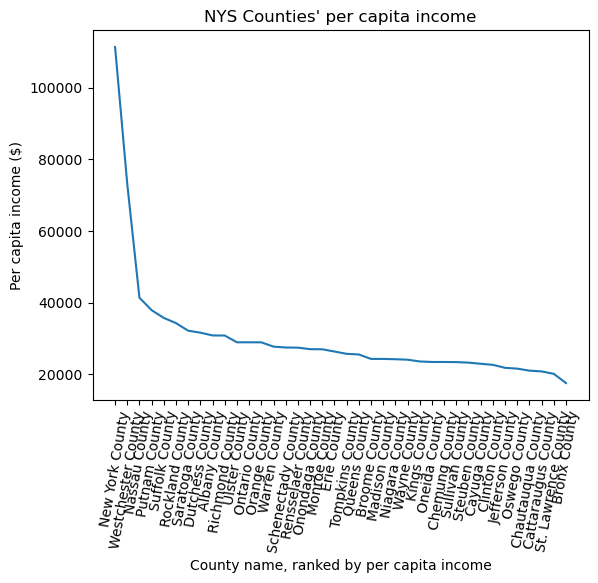

In [1694]:
#display general trend of each county (ranked by per capita income) vs. their per capita income
general_graph = plt.plot(ageless_merged_df['County'], ageless_merged_df['Per capita income'])
plt.title("NYS Counties' per capita income")
plt.xlabel("County name, ranked by per capita income")
plt.ylabel("Per capita income ($)")
plt.xticks(rotation=80)
display(general_graph)

We will now display a stacked bar graph depicting the college major makeup of each county:

ConversionError: Failed to convert value(s) to axis units: [0     38.30
1     36.60
2     32.60
3     27.30
4     31.50
5     31.60
6     43.00
7     34.50
8     42.80
9     33.30
10    29.50
11    35.00
12    31.70
13    32.60
14    39.40
15    39.60
16    33.10
17    38.30
18    32.20
19    51.10
20    35.50
21    39.50
22    39.00
23    30.50
24    39.20
25    35.30
26    34.60
27    32.00
28    31.70
29    36.20
30    33.60
31    26.30
32    34.20
33    35.20
34    30.70
35    34.50
36    34.30
37    32.90
Name: Science and Engineering, dtype: object]

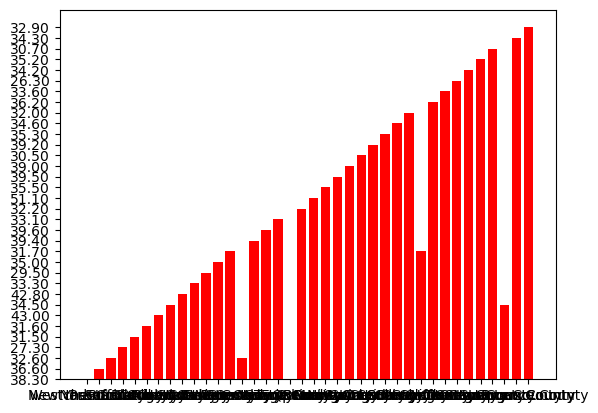

In [1710]:
plt.bar(ageless_merged_df['County'], ageless_merged_df['Science and Engineering'], color = 'red')
plt.bar(ageless_merged_df['County'], ageless_merged_df['Science and Engineering Related Fields'], bottom = [ageless_merged_df['Science and Engineering']], color = 'blue')
#plt.bar(ageless_merged_df['County'], ageless_merged_df['Business'], bottom= ageless_merged_df['Science and Engineering']+ageless_merged_df['Science and Engineering Related Fields'], color = 'green')
#plt.bar(ageless_merged_df['County'], ageless_merged_df['Education'], bottom = ageless_merged_df['Science and Engineering']+ageless_merged_df['Science and Engineering Related Fields']+ ageless_merged_df['Business'], color = 'yellow')
#stacked_bar = ageless_merged_df.plot(kind="bar", stacked=True, color=['blue', 'green', 'red', 'yellow', 'purple'])
#stacked_bar = ageless_merged_df.set_index('County').plot(kind="bar", stacked=True, color=['blue', 'green', 'red', 'yellow', 'purple'])

## Data Limitations

- The Census data is limited in that it is essentially a large sample, as it does not cover the entire population, and typically, more vulnerable groups are not represented. 
- This data and any findings from it cannot be generalized to any region outside New York State, as the only counties considered are New York State counties. Especially considering that the state has one of the biggest and most wealthy cities in the world, this is unlikely to be validly mapped to another region. In the same regard, the universities of New York residents are most likely composed of disproportionately more in-state colleges compared to other states, yet another reason to not generalize this data outside of New York. 
- Another limitation is that the Census lumps together a broad variety of majors into "STEM", "Humanities", etc. which may result in a lack of consideration of certain outliers within those major-groups. For example, Psychology may be considered STEM, but it may not follow the same trends as a Computer Science major.
- Another limitation is that the Wikepedia data is outdated by 13 years, as its most recent data is from 2010.

## Questions for reviewers

- How should we address the NaNs and divider columns (to divide the data by age) in the ageless_merged_df? Should we delete the column entirely and rename the columns inside of them to denote which belongs to which age group?
- Do you recommend visualizing the data in any other ways? We tried to cover all different variations of how the data could be looked at (all of the perspectives / comparisons) but we are unsure if our visualizations and computations are comprehensive enough.
- Can we improve any of our visualizations or graphs? (ex: change the axes, transformations, add different colors, change the graph type)
- Do you have any suggestions / recommendations regarding our concept overall? Should we be more specific in our research question? Should we reconsider how our dataframes are merged / structured or our process in general?